# Introduction
 This project will be based on the work *Time-Series Study of Associations between Rates of People Affected by Disasters and the El Niño Southern Oscillation (ENSO) Cycle* by Holly Ching Yu Lam, Andy Haines, Glenn McGregor, Emily Ying Yang Chan, and Shakoor Hajat. In the paper, Lam et al. aim at examining the annual relationships between El Niño years and PAD rates. To find the relationships, researchers perform time series regression analysis exploring the connection between ONI & MEI and PAD rates, through which they discover an annual relationship between the data. To conclude their findings, PAD rates were significantly higher during El Niño years, and the disasters typically include storms and floods. 

We will investigate ENSO indices and perform analysis on three time series: people affected by disaster(PAD) rates per 1000, Ocean Niño Index(ONI) and multivariate El Niño Index(MEI). (Lam et al., 2019) In addition, we will also perform time series analysis on Southern Oscillation Index(SOI), which may possess similar pattern as the time series data that were examined by Lam et al.(Climatic Research Unit, 2019)





# Methods

### **Installing Packages**


For our projcet, the only package we will be using for time series analysis is the "tswge" package as shown below.

In [1]:
install.packages("tswge")
library("tswge")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### **Loading Datasets**

We downloaded the datasets required for our analysis and converted them into ".csv" files through RStudio. Then, we uploaded all .csv files to the "File" section of Google Colab.

Links to datasets:
1. ONI: https://psl.noaa.gov/data/correlation/oni.data
1. MEI: https://psl.noaa.gov/enso/mei/data/meiv2.data
1. PAD: https://public.emdat.be/data
1. POP: https://data.worldbank.org/indicator/SP.POP.TOTL
1. SOI: https://crudata.uea.ac.uk/cru/data/soi/


In [2]:
PAD.raw<-read.csv(file='/content/emdat_public_2021_03_05_query_uid-y24A75.csv',header=TRUE,skip=6)
POP.raw<-read.csv(file='/content/API_SP.POP.TOTL_DS2_en_csv_v2_2106202.csv')
ONI<-read.csv(file='/content/ONI.csv')
MEI<-read.csv(file='mei.csv')
SOI<-read.csv(file='soi.csv')

Here, we select specific columns of data that we are interested in and create subsets from the raw data.

In [3]:
PAD<-subset(PAD.raw,select=c(ISO,Start.Year,Total.Deaths,Total.Affected))
POP<-subset(POP.raw,select=-c(Indicator.Name,Indicator.Code))

### **Processing ONI Dataframe**
According to Lam et al., they use only the trimonthly average ONI data to perform time series analysis, so we subset the column of data out of the original dataset, which contains trimonthly averages for every month in a year. Then, we remove data from 1950 to 1963 and 2018 to 2021, since Lam et al. only focus on data from 1964 to 2017.

In [4]:
ONI.DJF<-ONI[ONI$SEAS=='DJF',]
ONI.DJF<-ONI.DJF[-c(1:14,69:72),]
ONI.ts <- ts(ONI.DJF$ANOM, start = 1964,end=2017, frequency = 1) 

### **Processing MEI Dataframe**
Lam et al. use only the bimonthly average MEI data to perform time series analysis, so we subset the column of data out of the original dataset, which contains bimonthly averages for every month in a year. We also create a time series for all monthly data in MEI for our analysis.

In [5]:
MEI.DJ<-MEI[-c(1:14),'DECJAN']
MEI<-MEI[-c(1:14),c(1:ncol(MEI))]

In [6]:
#Converting the MEI.DJ and MEI.all vector to a time series.
MEI.ts <- ts(MEI.DJ, start = 1964, frequency = 1) 
MEI.all<-as.vector(t(MEI[,2:ncol(MEI)]))
MEI_all.ts<-ts(MEI.all, start = c(1964,1), frequency = 12)

### **Processing PAD Dataframe**
Here, we apply the conditions Lam et al. use to select disaster events. The conditions are : (1) those that caused 10 deaths or more; (2) those that affected 100 people or more. Before we process the data, we first need to replace all "NA" values with 0's so that the calculation later will not yield null results.

In [7]:
PAD[is.na(PAD)] <- 0
list<-c()
for (i in 1:nrow(PAD)){
  if (PAD[i,'Total.Affected']<100){
    list<-c(list,i)
  }
}
list<-c()
for (i in 1:nrow(PAD)){
  if (PAD[i,'Total.Deaths']<10){
    list<-c(list,i)
  }
}

Since the rows of PAD dataframe contains the number of people affected by year and countries, we need to aggregate the total with respect to year. From the following lines, we produce a total for each year from 1964 to 2017 and create a new dataframe with "no_affected" vector and a year vector.

In [8]:
no_affected<-c()
for (i in 1964:2017){
  sum=0
  for (r in 1:nrow(PAD)){
    if (PAD[r,'Start.Year']==i){
      sum=sum+PAD[r,'Total.Affected']
    }
  }
  no_affected<-c(no_affected,sum)
}


In [9]:
PAD.rate<-data.frame(c(1964:2017),no_affected)
colnames(PAD.rate)<-c('Year','Total.Affected')

Below, we remove years of data we do not need from POP dataframe and replace all "NA" with 0's to avoid errors in calculations. 

In [10]:
POP<-POP[,-c(3:6,61:62)]
POP[is.na(POP)] <- 0


The following lines produce a population vector with each element being the population sum of countries appeared in PAD dataframe in a given year. We did not include any countries that were not in PAD or POP.

In [11]:
pop<-c()
for (i in 1964:2017){
  sum=0
  countries<-c()
  for (r in 1:nrow(PAD)){
    if (PAD[r,'Start.Year']==i){
        countries<-c(countries,PAD[r,'ISO'])  
    }
  }
  countries<-unique(countries)
  for (item in countries){
    if (any(POP$Country.Code==item)==TRUE){
      sum=sum+POP[which(POP$Country.Code==item),paste0('X',i)]
    }
  }
  pop<-c(pop,sum)
}

We append the population vector to PAD.rate dataframe and calculate the PAD rates per 1000 people. We then convert the rates vector to a time series.

In [12]:
PAD.rate$Population=pop
PAD.rate$Rates=PAD.rate$Total.Affected/PAD.rate$Population*1000

In [13]:
PADrate.ts <- ts(PAD.rate$Rates, start = 1964,end=2017, frequency = 1) 

### **Processing SOI Dataframe**
Here we aggregate values in rows from 1964 to 2017, turning them into a vector, and convert it to a time series.

In [14]:
colnames(SOI)<-c(1:12)
SOI.all<-as.vector(t(SOI[99:152,1:12]))
SOI.ts <- ts(SOI.all, start = c(1964,1), frequency = 12) 

# Results

### **Reproducing Fiqure 1**


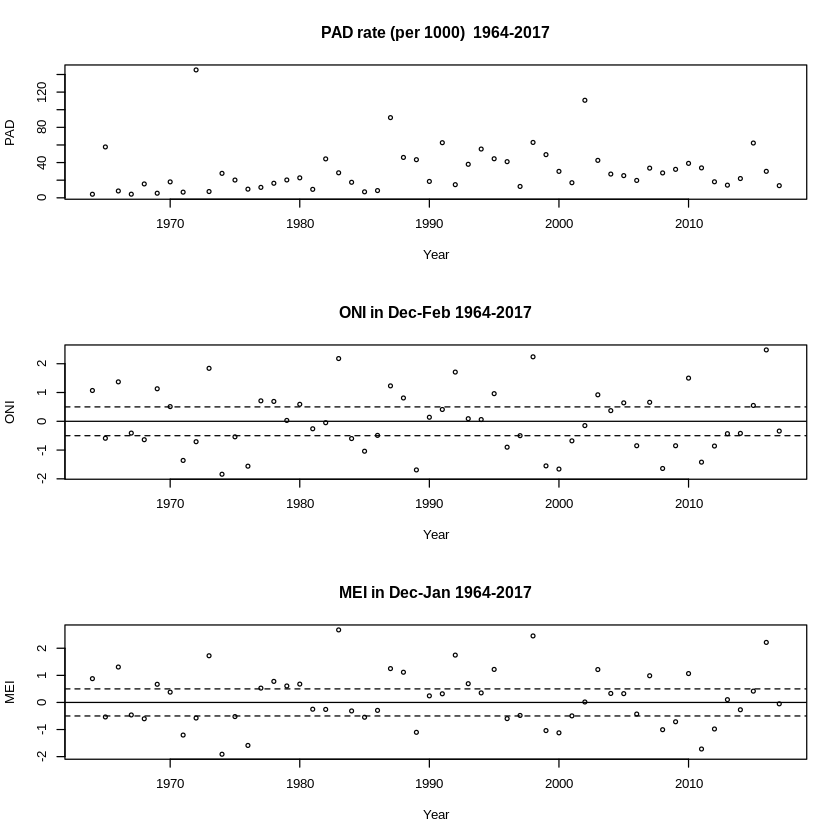

In [15]:
par(mfrow=c(3,1))
plot(PADrate.ts, main="PAD rate (per 1000)  1964-2017",type='p',xlab='Year',ylab='PAD')
plot(ONI.ts, main="ONI in Dec-Feb 1964-2017",type='p',xlab='Year',ylab='ONI')
abline(0.5,0, lty=2)
abline(-0.5,0, lty=2)
abline(0,0, lty=1)
plot(MEI.ts, main="MEI in Dec-Jan 1964-2017",type='p',xlab='Year',ylab='MEI')
abline(0.5,0, lty=2)
abline(-0.5,0, lty=2)
abline(0,0, lty=1)

### **ONI Time Series Analysis**

[1] 0.02344666

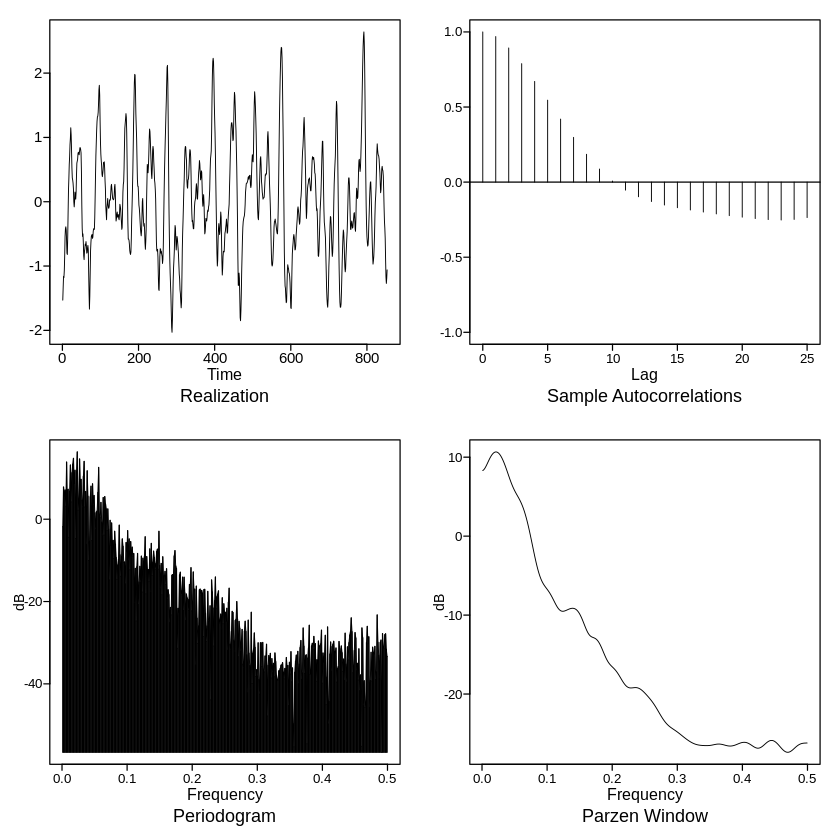

In [16]:
ONI_plot<-plotts.sample.wge(ONI$ANOM)
ONI_plot$freq[which.max(ONI_plot$db)]

The plots above shows that ONI is a stationary time series without seaonality. From the Sample Autocorrelations plot, we see autocorrelations taper off as number of lag increases. The Spectrail Density plot shows a peak at around $f=0.01$, which indicates that it is aperiodic or has a very long period. The dominant frequency is at $f=0.02345$, which yields a periodic behavior of 43 months, and the next dominant frequncy is around $f=0.12$. 

### **MEI Time Series Analysis**

[1] 0.02314815

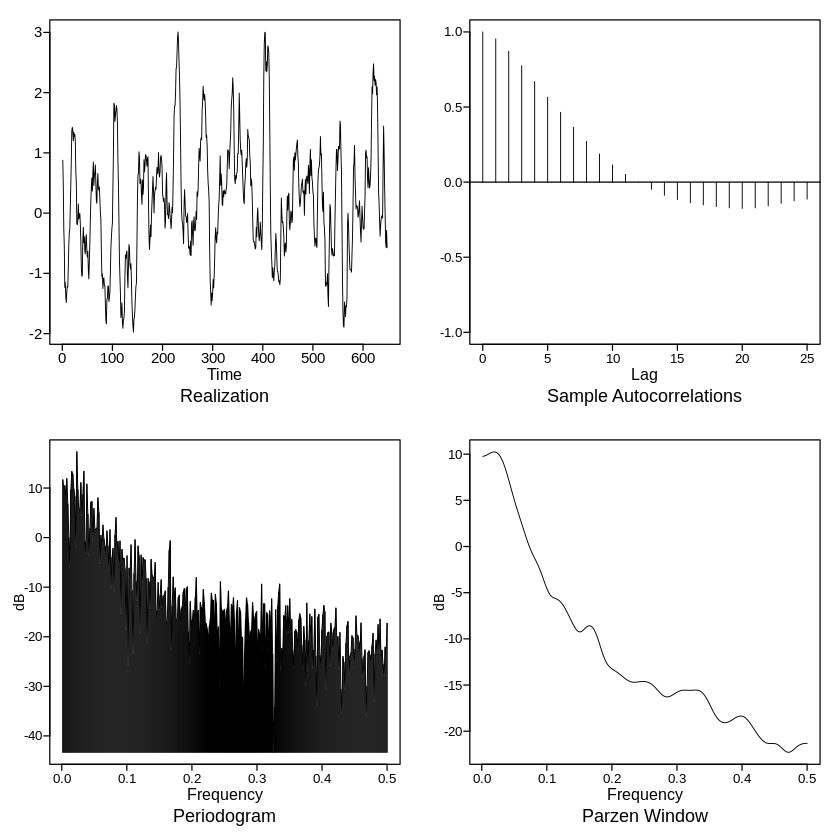

In [17]:
MEI_plot<-plotts.sample.wge(MEI_all.ts)
MEI_plot$freq[which.max(MEI_plot$db)]

The plots above shows that MEI is also a stationary time series without seaonality. In addition, it has a very similar shape as ONI. From the Sample Autocorrelations plot, we see autocorrelations taper off as number of lag increases. The Spectrail Density plot shows a peak at around $f=0.01$, which indicates that it is aperiodic or has a very long period. The dominant frequency is at $f=0.02315$, which yields a periodic behavior of 43 months, and the next dominant frequncy is around $f=0.17$. 

### **PAD Rates Time Series Analysis**

[1] 0.462963

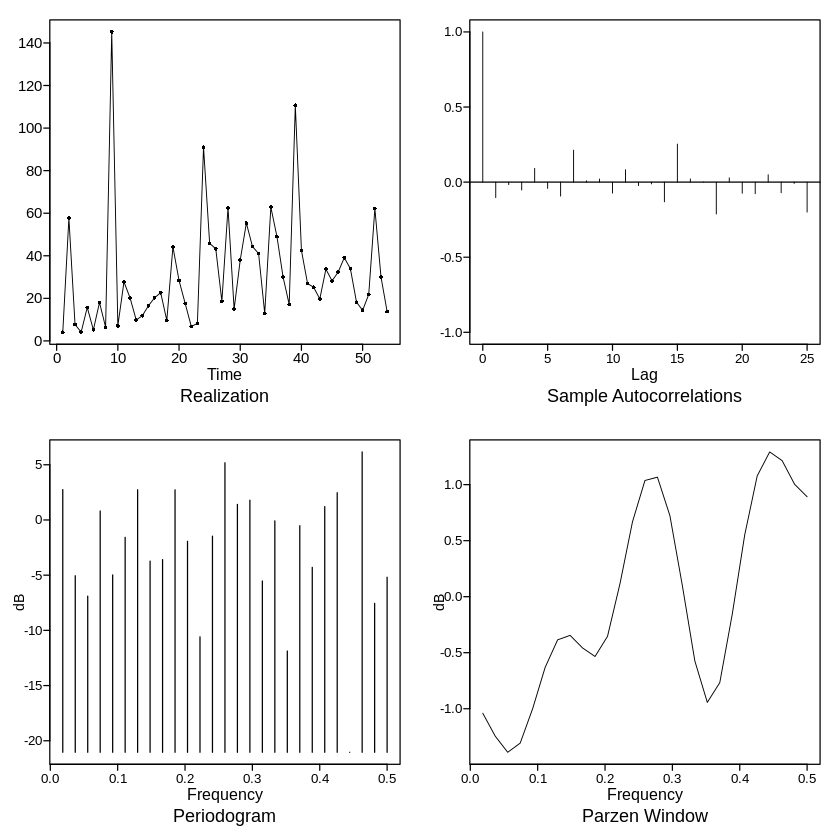

In [18]:
PAD_plot<-plotts.sample.wge(PAD.rate$Rates)
PAD_plot$freq[which.max(PAD_plot$db)]

The plots above shows that PAD rate could be a non-stationary time series since it seems to be increasing over time. From the Sample Autocorrelations plot, we see autocorrelations taper off after lag 0. The plots also show a periodic behavoir. The dominant frequency is at $f=0.4630$, which yields a periodic behavior of 2.15 years, and the next dominant frequncy is around $f=0.27$. 

### **SOI Time Series Analysis**

[1] 0.02314815

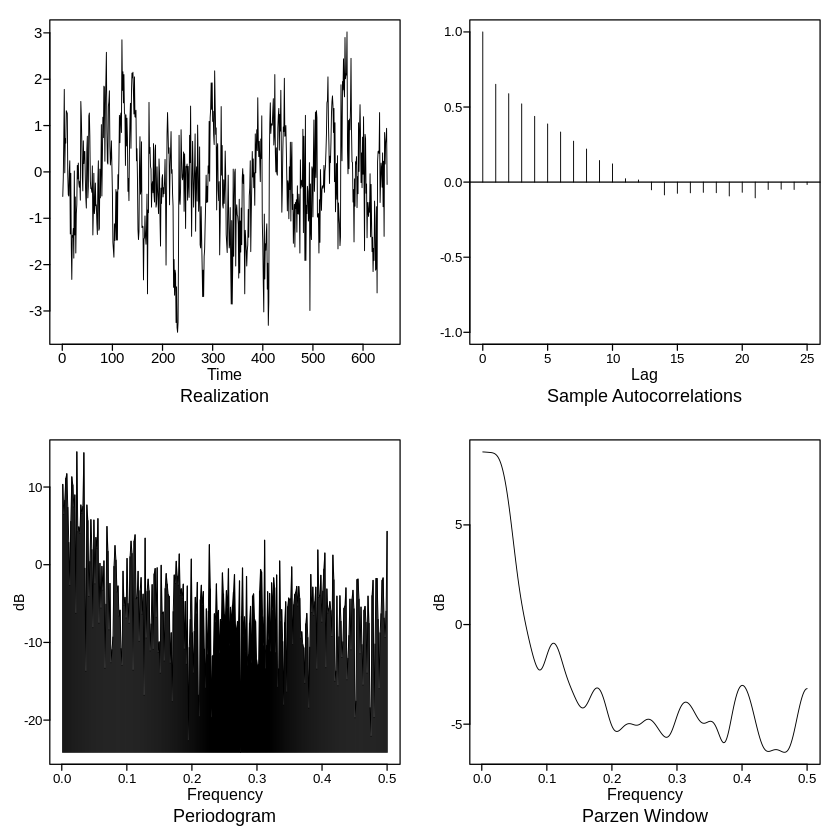

In [19]:
SOI_plot<-plotts.sample.wge(SOI.ts)
SOI_plot$freq[which.max(SOI_plot$db)]

Similar to ONI and MEI, the plots above shows that SOI is a stationary time series without seasonality. From the Sample Autocorrelations plot, we see autocorrelations taper off after as the number of lags increases. The dominant frequency is at $f=0.02315$, which yields a periodic behavior of 43 years, and the next dominant frequncy is around $f=0.11$. 

### **Identifying El Niño Years**

In the following lines, we create a subset of ONI.DJF and assign a value of 0 to all values less than 0.5, and a value of 1 to all other values. Then we display a talbe of El Niño years.

In [20]:
ONI_STND<-ONI.DJF[,-c(1,3)]
for (i in 1:nrow(ONI_STND)){
  if (ONI_STND[i,2]>=0.5){
    ONI_STND[i,2]=1
  } else {
    ONI_STND[i,2]=0
  }
}
ONI_STND

,YR,ANOM
,<int>,<dbl>
169,1964,1
181,1965,0
193,1966,1
205,1967,0
217,1968,0
229,1969,1
241,1970,1
253,1971,0
265,1972,0


# Discussion and Conclusions

### **Dominant Frequencies of ONI, MEI, and SOI**

Since the additional dataset, SOI, records similar event as ONI and MEI, they all yield a dominant frequency of around 0.0234, which calculated to be a period of 43 months or 3.58 years.

### **El Niño Years**

From the metrics descriped in the paper, any year with a index value greater than 0.5 is an El Niño year. From Figure 1 that we reproduced, we can see that El Niño event is most significant in the mid-60s, -70s, -80s, -90s. In addition, it seems from the El Niño years table that the event occur for around every 3 or 4 years, which match with the period of 43 months calculated from the dominant frequencies of ONI, MEI, and SOI.

### **Conclusion**

Over the course of this project, we conduct time series analysis on ENSO and PAD data and find El Niño years. For analyzing time series data, we use sample autocorrelation, periodogram, time series plot, and Parzen window. We are able to obtain the dominant frequency, periodic behavior, and stationarity for each time series and use them to identify El Niño years. Furthermore, we standardize the ONI values from December to February by assigning 0's and 1's to the dataframe and generating a table for a direct approximation. The result matches with the period we calculate in time seris analyses.

However, the relationship between PAD rates and El Niño years is not very clear and more steps of analysis could be taken to further reveal the relationship. 

One of the challenges in this project is to aggregate population by countries and years. During calculations, the lines of code would often return null values ( numeric(0) ) and there had been much time spent debugging.

# References

EM-DAT Public. (2021). https://public.emdat.be/

Lam, H. C. Y., Haines, A., McGregor, G., Chan, E. Y. Y., & Hajat, S. (2019). Time-Series Study of Associations between Rates of People Affected by Disasters and the El Niño Southern Oscillation (ENSO) Cycle. International Journal of Environmental Research and Public Health, 16(17), 3146. https://www.mdpi.com/1660-4601/16/17/3146/htm#B24-ijerph-16-03146

Population, total | Data. (2019). The World Bank. https://data.worldbank.org/indicator/SP.POP.TOTL

Southern Oscillation Index (SOI) data. (2019). https://crudata.uea.ac.uk/cru/data/soi/

Team, C. I. (2020). Climate Prediction Center - ONI. Climate Prediction Center. https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

Team, P. W. (2021). MEI.v2: NOAA Physical Sciences Laboratory. Physical Sciences Laboratory. https://psl.noaa.gov/enso/mei/

